In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *

In [3]:
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [4]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

### Training Demo

In [ ]:
pnts, radius_fun, amplitudes, phases = generate_random_star_shape_torch(1000, num_modes=10)
pnts = pnts.float()
device = get_device()
model = UNetBlockStyleMLP_backbone(ndim=2, nlayers=5, nhidden=64, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=2000, batch_size=1024, device=device)


  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 loss 1.846


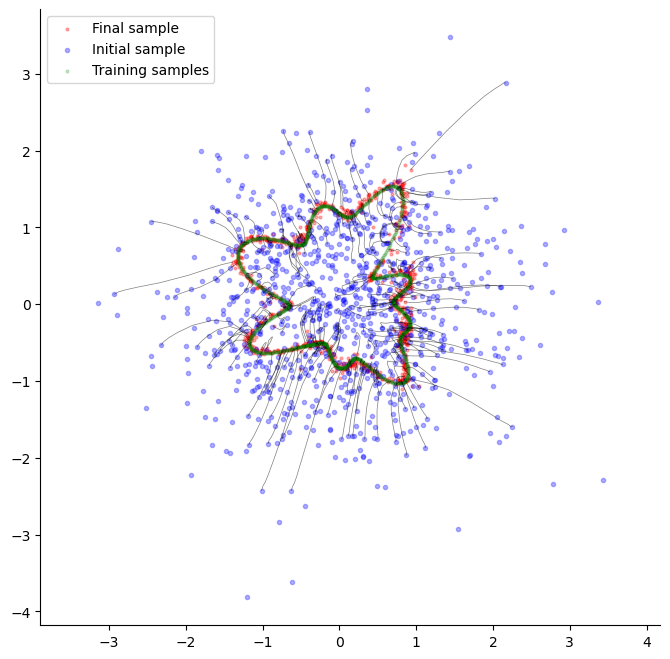

In [10]:
import os
from os.path import join
savetmpdir = join(saveroot, "star_shape_demo")
os.makedirs(savetmpdir, exist_ok=True)

noise_init = torch.randn(1000, 2).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8,8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
saveallforms(saveroot, "demo_edm_sampler_star_shape")
plt.show()

### Gaussian Data Spectral convergence

In [7]:
!mkdir $STORE_DIR/DL_Projects/DiffusionSpectralLearningCurve

In [8]:
!echo $STORE_DIR/DL_Projects/DiffusionSpectralLearningCurve

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve


In [5]:
record_step_list = [*range(0, 10, 1), *range(10, 50, 2), *range(50, 100, 4), *range(100, 500, 8), *range(500, 2500, 16), 
                    *range(2500, 5000, 32), *range(5000, 10000, 64)]

True covariance trace 128.0
Estimated training sample covariance trace 128.0510711669922


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 2.665


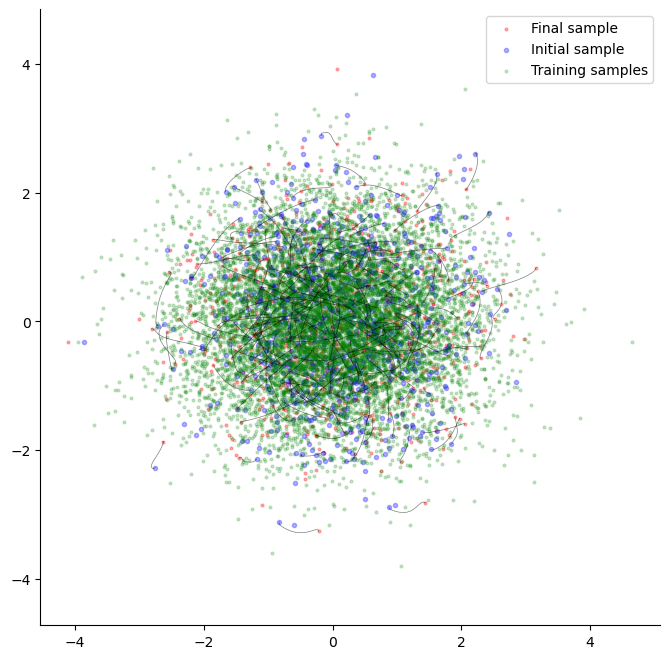

In [20]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out,

# pnts, radius_fun, amplitudes, phases = generate_random_star_shape_torch(1000, num_modes=10)
# create a 10 x 10 covariance matrix with non white spectrum
ndim = 128
savedir = f"{saveroot}/GaussianData/ndim{ndim}_small_lr_width256" # "
os.makedirs(savedir, exist_ok=True)
device = get_device()
# diag_var = torch.rand(ndim, device=device)
diag_var = torch.exp(torch.randn(ndim, device=device))
diag_var = torch.sort(diag_var, descending=True)[0]
diag_var = diag_var / diag_var.mean() 
diag_std = diag_var.sqrt()
cov = torch.diag(diag_var)
# rot = torch.eye(ndim, device=device)
# rotate the covariance matrix with a random rotation matrix
rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]
cov = rot @ cov @ rot.T
pnts = torch.randn(10000, ndim).to(device)
pnts = pnts @ torch.diag(diag_std) @ rot.T
cov_empirical = torch.cov(pnts.T, correction=1)
print("True covariance trace", torch.trace(cov).item()) # ~ 10
print("Estimated training sample covariance trace", torch.trace(cov_empirical).item()) # ~ 13.2

pnts = pnts.float()
device = get_device()
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=256, time_embed_dim=256,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.0001, nepochs=5000, batch_size=1024, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()

pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

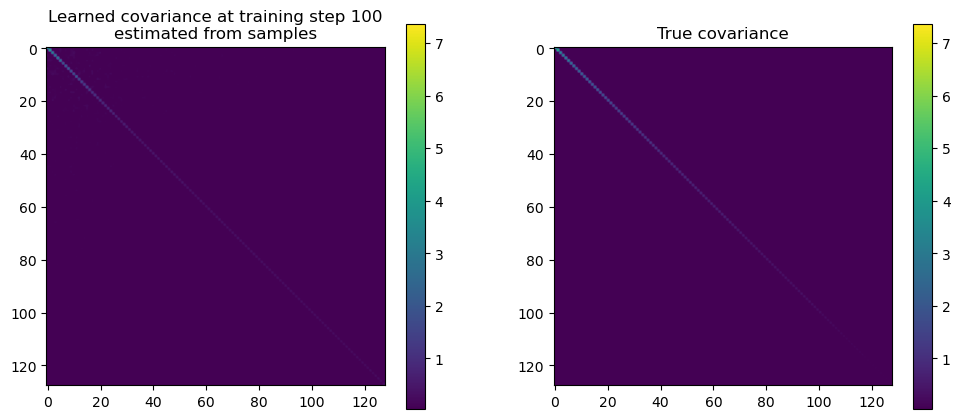

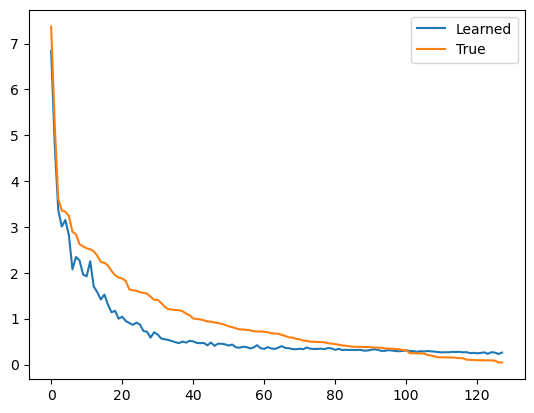

In [188]:
training_step = 100
x_traj, x0hat_traj, t_steps = sample_store[training_step]
cov_x_sample = torch.cov(x_traj[-1].T).to(device)
# try estimate the variance along the eigenvector of the covariance matrix
cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
cov_true_eigenbasis = rot.T @ cov @ rot
diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
diag_cov_true_eigenbasis = torch.diag(cov_true_eigenbasis)

vmin = min(diag_cov_x_sample_true_eigenbasis.min(), diag_cov_true_eigenbasis.min())
vmax = max(diag_cov_x_sample_true_eigenbasis.max(), diag_cov_true_eigenbasis.max())
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(cov_x_sample_true_eigenbasis.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Learned covariance at training step {training_step}\nestimated from samples")
plt.subplot(122)
plt.imshow(cov_true_eigenbasis.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("True covariance")
plt.show()
plt.plot(diag_cov_x_sample_true_eigenbasis.cpu().numpy(), label="Learned")
plt.plot(diag_cov_true_eigenbasis.cpu().numpy(), label="True")
plt.legend()
plt.show()

In [88]:

def process_pnts_mean_cov_statistics(train_pnts, sample_store, savedir, device="cuda",):
    train_X_mean = train_pnts.mean(dim=0)
    train_X_cov = torch.cov(train_pnts.T)
    train_X_eigval, train_X_eigvec = torch.linalg.eigh(train_X_cov.to(device))
    train_X_eigval = train_X_eigval.flip(0)
    train_X_eigvec = train_X_eigvec.flip(1)
    train_X_eigvec = train_X_eigvec.to(device)
    print(f"train_X_eigval.shape: {train_X_eigval.shape} computed on {train_pnts.shape[0]} samples")
    mean_x_sample_traj = []
    cov_x_sample_traj = []
    diag_cov_x_sample_true_eigenbasis_traj = []
    step_slice = sorted([*sample_store.keys()])
    for training_step in tqdm(step_slice):
        x_final = sample_store[training_step]
        if isinstance(x_final, tuple):
            x_final = x_final[0]
        x_final_patches = x_final.view(x_final.shape[0], -1)
        mean_x_sample = x_final_patches.mean(dim=0)
        cov_x_sample = torch.cov(x_final_patches.to(device).T)
        mean_x_sample_traj.append(mean_x_sample.cpu())
        # Estimate the variance along the eigenvector of the covariance matrix
        cov_x_sample_true_eigenbasis = train_X_eigvec.T @ cov_x_sample.to(device) @ train_X_eigvec
        diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
        diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
        cov_x_sample_traj.append(cov_x_sample.cpu())
    
    mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
    cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
    diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

    pkl.dump({
        "diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj, 
        "mean_x_sample_traj": mean_x_sample_traj,
        "cov_x_sample_traj": cov_x_sample_traj,
        "train_X_mean": train_X_mean.cpu(),
        "train_X_cov": train_X_cov.cpu(),
        "train_X_eigval": train_X_eigval.cpu(),
        "train_X_eigvec": train_X_eigvec.cpu(),
        "step_slice": step_slice
    }, open(f"{savedir}/sample_pnts_cov_true_eigenbasis_diag_traj.pkl", "wb"))
    print(f"Saved to {savedir}/sample_pnts_cov_true_eigenbasis_diag_traj.pkl")
    return train_X_mean, train_X_cov, train_X_eigval, train_X_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj

In [22]:
def plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval, slice2plot,
                               savedir, dataset_name="Gaussian"):
    ndim = train_X_eigval.shape[0]
    max_eigid = max(range(ndim)[slice2plot])    
    plt.figure()
    plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
    for i, eigid in enumerate(range(ndim)[slice2plot]):
        plt.axhline(train_X_eigval[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Variance")
    plt.title(f"Variance of learned samples on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {train_X_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_pnts_cov_true_eigenbasis_diag_traj_raw_top{max_eigid}")
    plt.show()

    plt.figure()
    diag_cov_x_sample_true_eigenbasis_traj_normalized = diag_cov_x_sample_true_eigenbasis_traj / train_X_eigval
    plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj_normalized[:, slice2plot], alpha=0.7)
    plt.axhline(1, color="k", linestyle="--", alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Variance [normalized by target variance]")
    plt.title(f"Variance of learned samples on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {train_X_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_pnts_cov_true_eigenbasis_diag_traj_normalized_top{max_eigid}")
    plt.show()

# Example usage:
# plot_variance_trajectories(step_slice, diag_cov_x_patch_sample_true_eigenbasis_traj, patch_eigval, patch_size, patch_stride, savedir)

def plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean, train_X_eigvec, train_X_eigval, 
                                     slice2plot, savedir, dataset_name="Gaussian"):
    train_X_mean_vec = train_X_mean.view(-1)
    mean_deviation_traj = (mean_x_sample_traj - train_X_mean_vec) @ train_X_eigvec.cpu()
    MSE_per_mode_traj = mean_deviation_traj.pow(2)
    MSE_per_mode_traj_normalized = MSE_per_mode_traj / train_X_eigval.cpu()
    ndim = train_X_eigval.shape[0]
    max_eigid = max(range(ndim)[slice2plot])    

    plt.figure()
    plt.plot(step_slice, mean_deviation_traj[:, slice2plot], alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Training step")
    plt.ylabel("mean deviation")
    plt.title(f"Mean deviation of learned samples on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {train_X_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_pnts_mean_dev_eigenbasis_traj_raw_top{max_eigid}")
    plt.show()

    plt.figure()
    plt.plot(step_slice, MSE_per_mode_traj[:, slice2plot], alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Squared error of mean deviation")
    plt.title(f"Mean deviation of learned samples on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {train_X_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_pnts_mean_SE_eigenbasis_traj_raw_top{max_eigid}")
    plt.show()

    plt.figure()
    plt.plot(step_slice, MSE_per_mode_traj_normalized[:, slice2plot], alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Squared error of mean deviation\n[normalized by target variance]")
    plt.title(f"Mean deviation of learned samples on true eigenbasis | {dataset_name}")
    plt.gca().legend([f"Eig{i} = {train_X_eigval[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
    saveallforms(savedir, f"sample_pnts_mean_SE_eigenbasis_traj_normalized_top{max_eigid}")
    plt.show()

In [23]:
train_X_mean, train_X_cov, train_X_eigval, train_X_eigvec, \
    mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
    process_pnts_mean_cov_statistics(pnts, sample_store, savedir, device="cuda")

train_X_eigval.shape: torch.Size([128]) computed on 10000 samples


  0%|          | 0/297 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128_small_lr_width256/sample_pnts_cov_true_eigenbasis_diag_traj.pkl


In [24]:
from os.path import join
figdir = join(savedir, "figures")
os.makedirs(figdir, exist_ok=True)


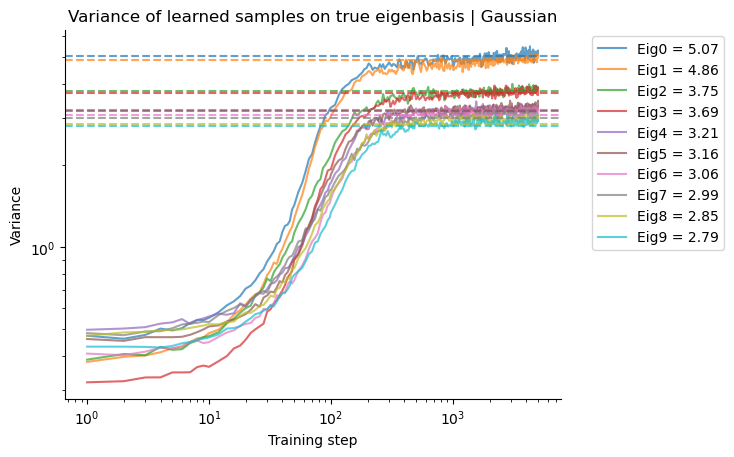

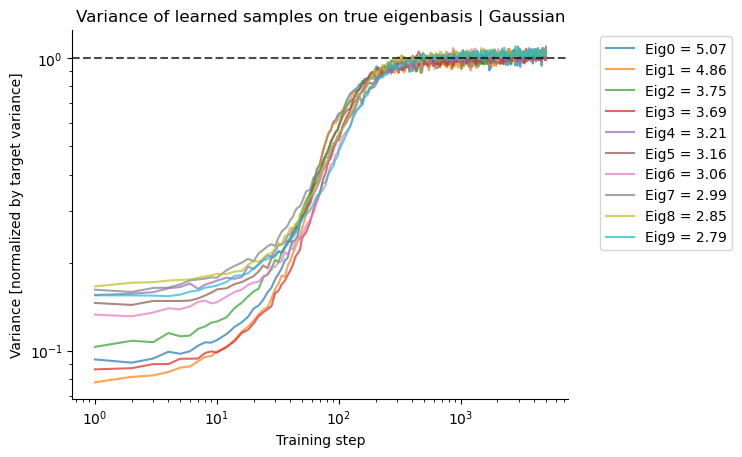

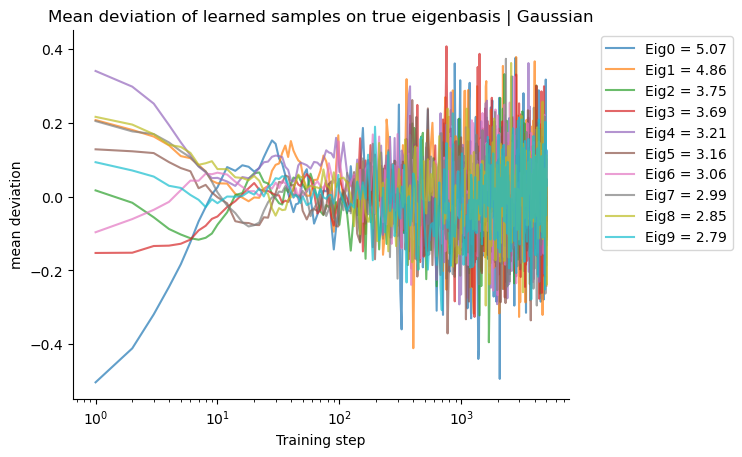

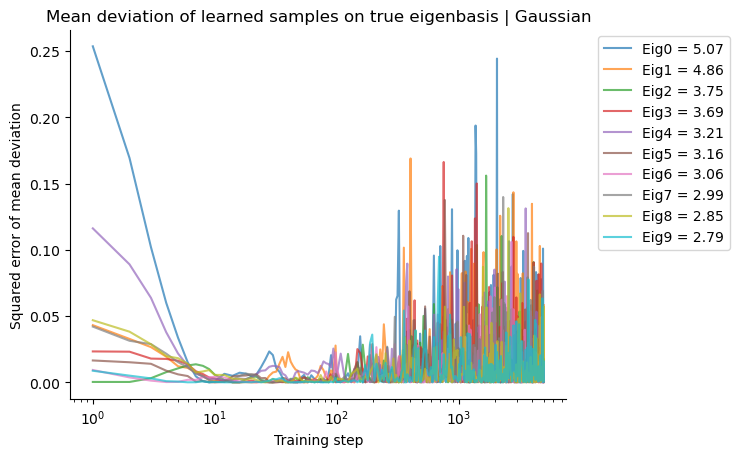

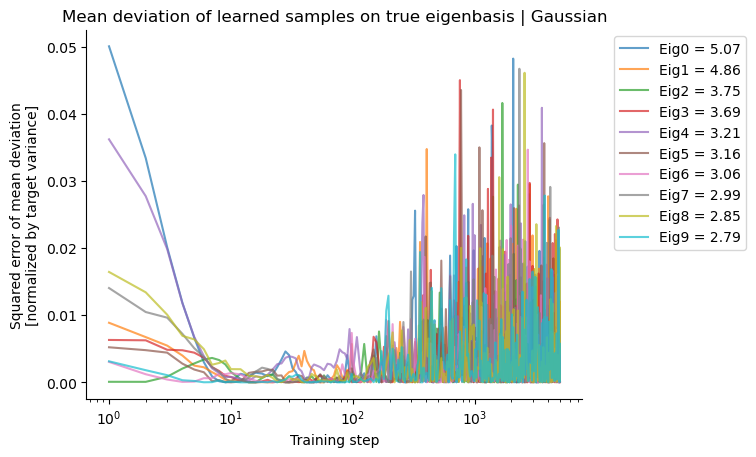

In [25]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 10, 1)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")

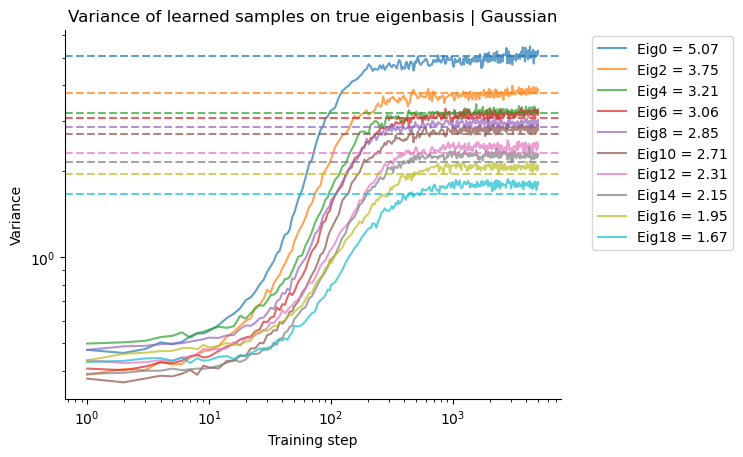

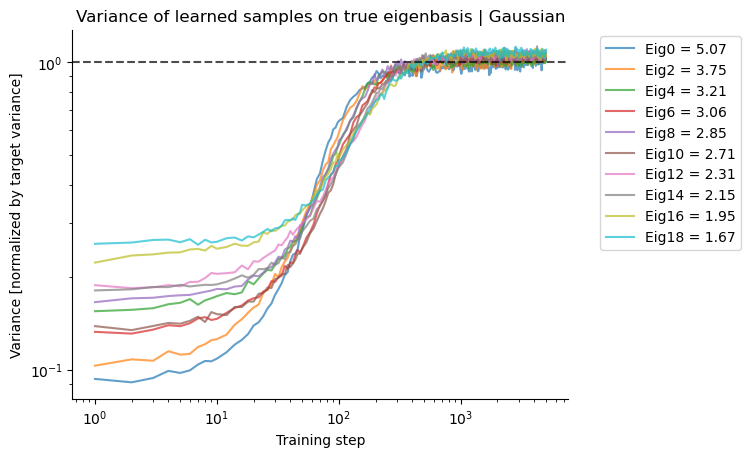

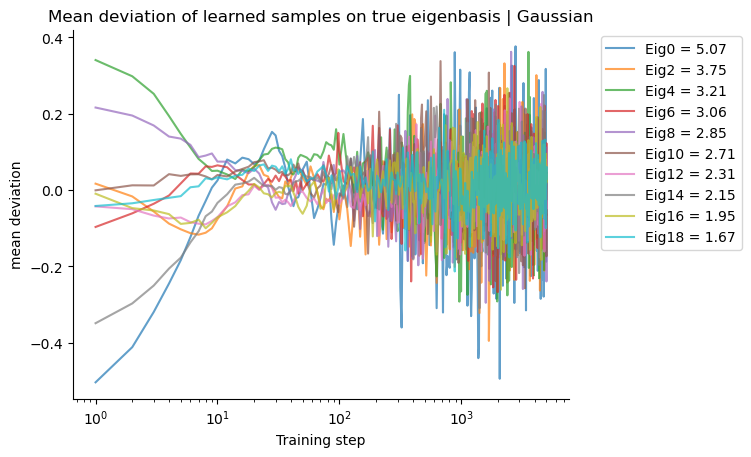

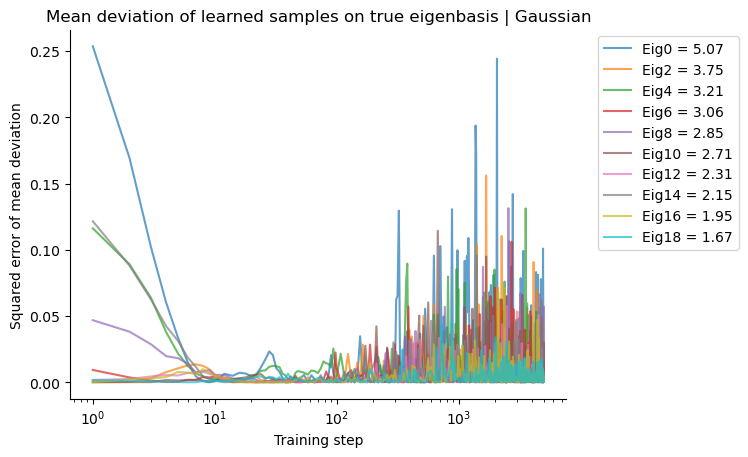

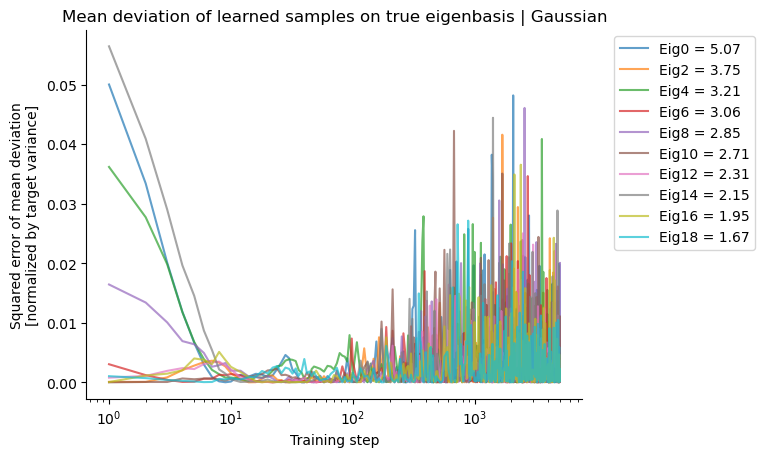

In [26]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 20, 2)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")

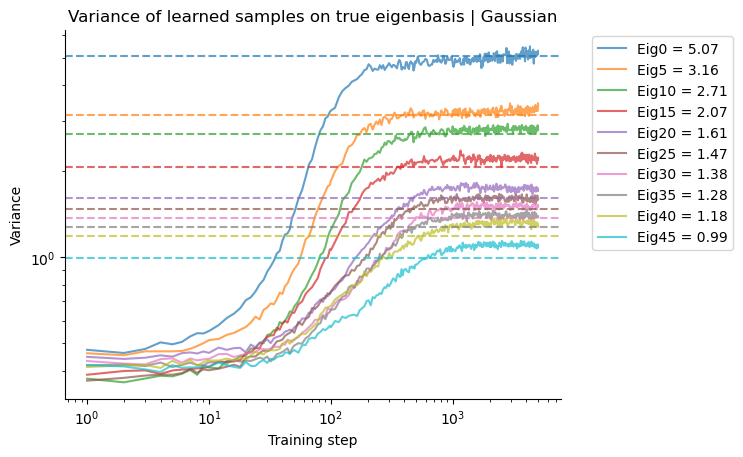

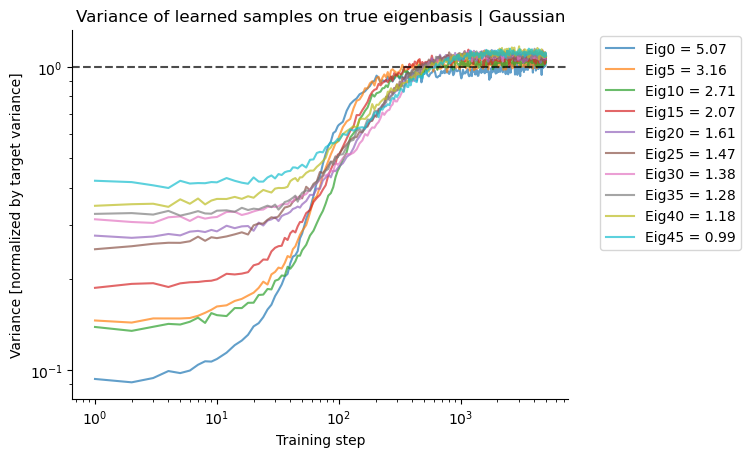

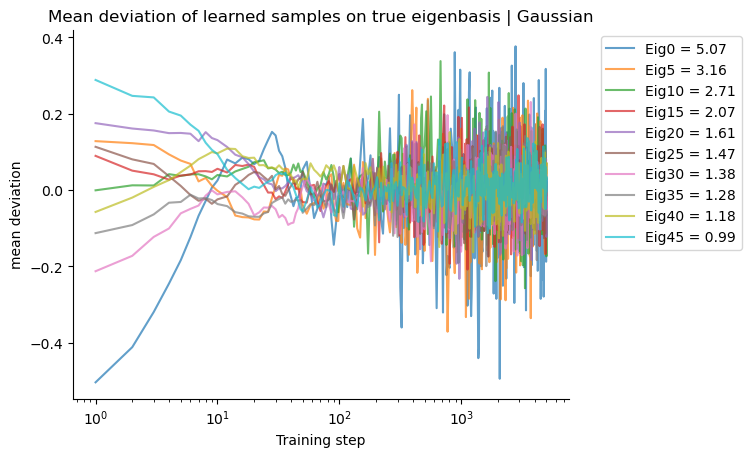

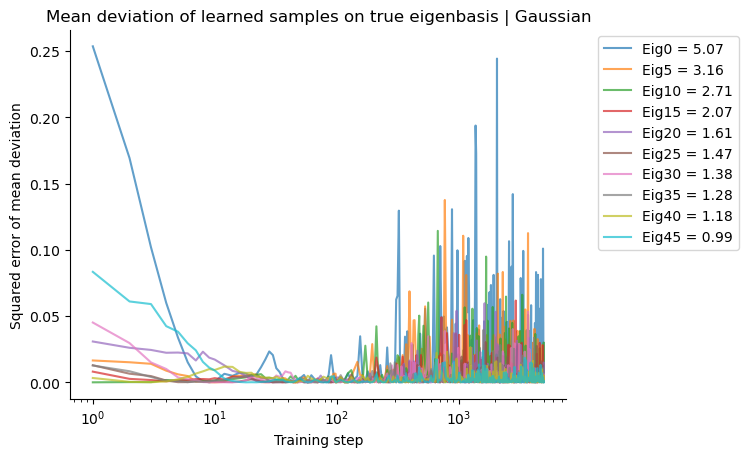

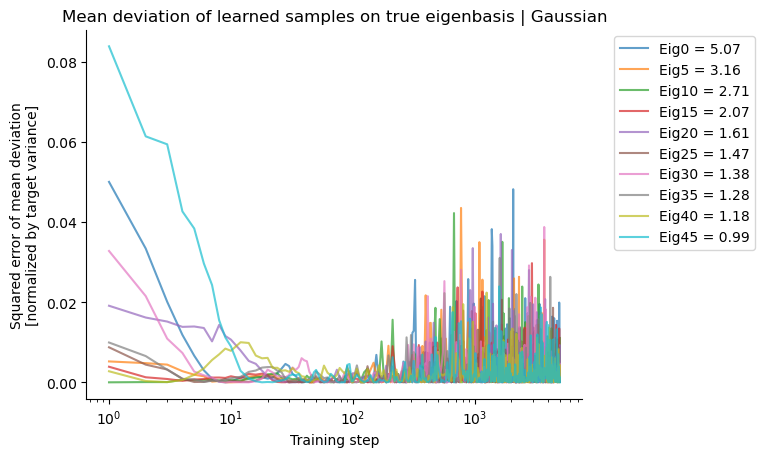

In [28]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 50, 5)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")

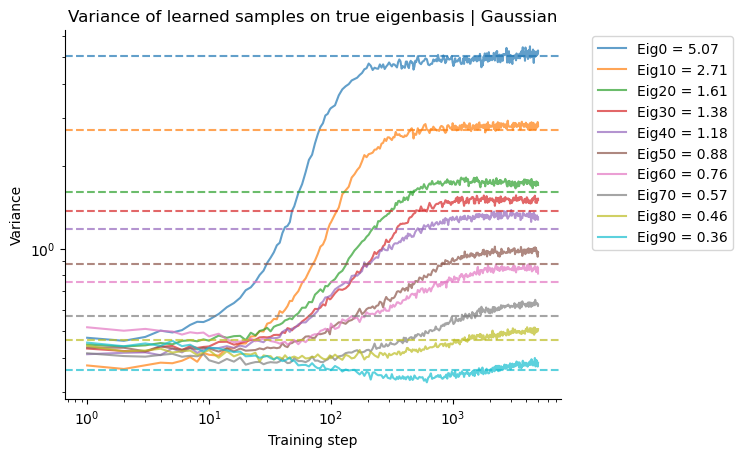

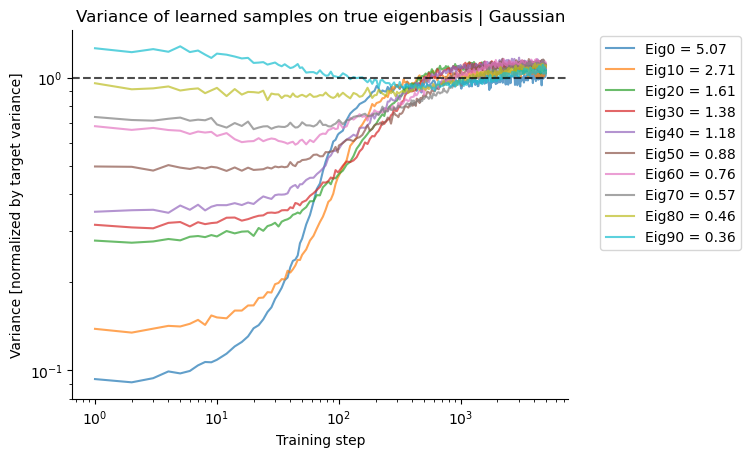

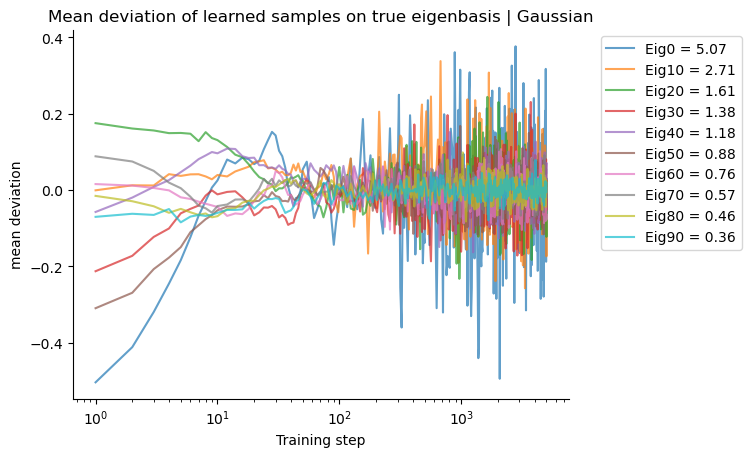

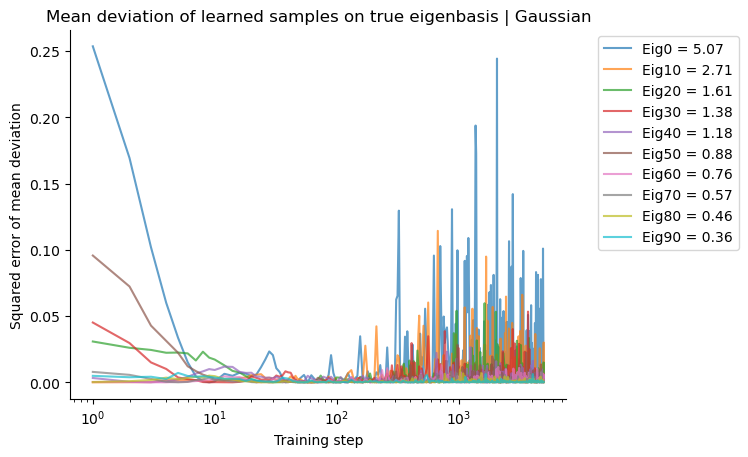

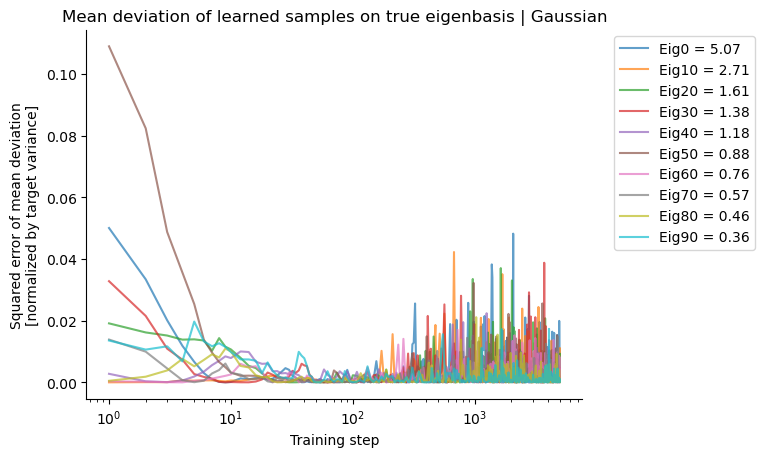

In [27]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 100, 10)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="Gaussian")

#### synopsis across modes

In [31]:
diag_cov_x_sample_true_eigenbasis_traj.shape


torch.Size([297, 128])

In [107]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def smooth_and_find_threshold_crossing(trajectory, threshold, first_crossing=False):
    if isinstance(trajectory, torch.Tensor):
        trajectory = trajectory.cpu().numpy()
    if isinstance(threshold, torch.Tensor):
        threshold = threshold.cpu().numpy()
    smoothed_trajectory = gaussian_filter1d(trajectory, sigma=2)
    # determine the direction of the crossing
    direction = 1 if smoothed_trajectory[0] > threshold else -1
    if direction == 1:
        crossing_indices = np.where(smoothed_trajectory < threshold)[0]
    else:
        crossing_indices = np.where(smoothed_trajectory > threshold)[0]
    if len(crossing_indices) > 0:
        return crossing_indices[0] if first_crossing else crossing_indices[-1], direction
    else:
        return None, direction


def harmonic_mean(A, B):
    return 2 / (1 / A + 1 / B)

In [67]:


# Example usage:
# Assuming diag_cov_x_sample_true_eigenbasis_traj is a numpy array of shape (num_steps, num_trajectories)
step_slice = sorted([*sample_store.keys()])
num_trajectories = diag_cov_x_sample_true_eigenbasis_traj.shape[1]
crossing_steps = []
directions = []
for i in range(num_trajectories):
    trajectory = diag_cov_x_sample_true_eigenbasis_traj[:, i]
    threshold = harmonic_mean(train_X_eigval[i], trajectory[0])
    crossing_idx, direction = smooth_and_find_threshold_crossing(trajectory, threshold)
    crossing_steps.append(step_slice[crossing_idx])
    directions.append(direction)

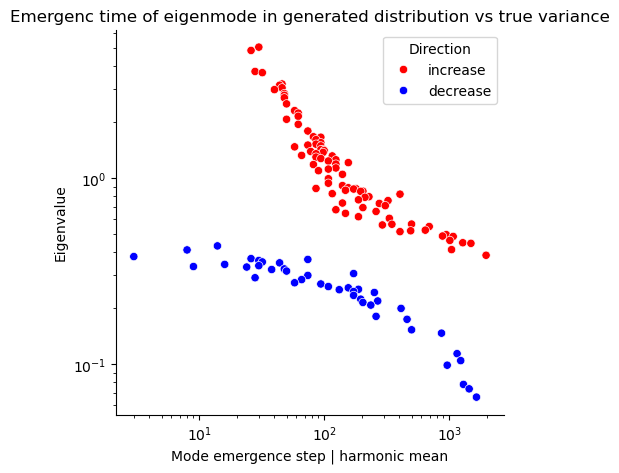

In [68]:
# make a dataframe
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"Variance": train_X_eigval.cpu().numpy(), "emergence_step": crossing_steps, "direction": directions})
# translate direction 1 -> decrease, -1 -> increase
df["Direction"] = df["direction"].map({1: "decrease", -1: "increase"})
# df.to_csv(f"{savedir}/crossing_points.csv", index=False)
figh = plt.figure(figsize=[5, 5])
# Decide which direction maps to which color
palette = {"decrease": "blue", "increase": "red"}
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", 
                palette=palette,)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title("Emergenc time of eigenmode in generated distribution vs true variance")
saveallforms(savedir, "synopsis_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()
df.to_csv(f"{savedir}/synopsis_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)

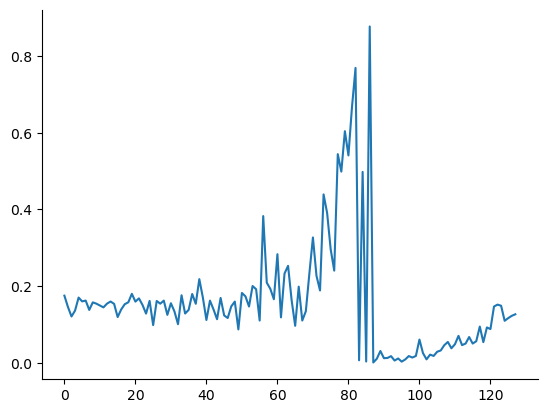

In [ ]:
plt.plot(df["Variance"] * df["emergence_step"] * 8 * 0.0001 / np.log(2) )
plt.show()

### Gaussian non centered Case

#### Dynamic interaction of mean and covariance

### Scratch space

Estimated sample covariance trace 7.940922260284424
True covariance trace 4.999999523162842


Text(0.5, 1.0, 'Learned covariance at training step 2000\nestimated from samples')

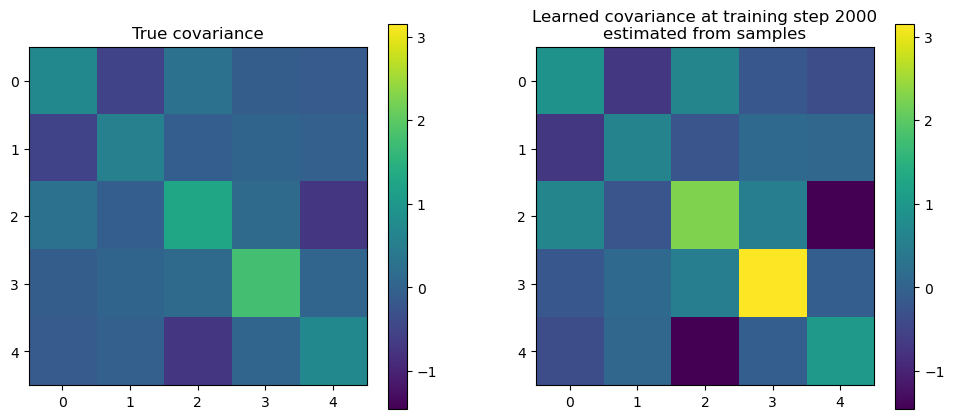

In [ ]:
training_step = 2000
x_traj, x0hat_traj, t_steps = sample_store[training_step]
cov_x_sample = torch.cov(x_traj[-1].T, correction=1) 
print("Estimated sample covariance trace", torch.diag(cov_x_sample).sum().item())
print("True covariance trace", torch.diag(cov).sum().item())
# print(x_traj.shape) # 21 x 10000 x 10
# print(x0hat_traj.shape) # 20 x 10000 x 10
# print(t_steps.shape) # 21

vmin = min(cov.cpu().numpy().min(), cov_x_sample.cpu().numpy().min())
vmax = max(cov.cpu().numpy().max(), cov_x_sample.cpu().numpy().max())
plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.imshow(cov.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("True covariance")
plt.subplot(122)
plt.imshow(cov_x_sample.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Learned covariance at training step {training_step}\nestimated from samples")

In [ ]:
ndim = 10
# diag_var = torch.rand(ndim, device=device)
diag_var = torch.exp(torch.randn(ndim, device=device))
diag_var = torch.sort(diag_var, descending=True)[0]
diag_var = diag_var / diag_var.mean() 
diag_std = diag_var.sqrt()
cov = torch.diag(diag_var)
# rotate the covariance matrix with a random rotation matrix
# rot = torch.eye(ndim, device=device)
rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]
cov = rot @ cov @ rot.T
pnts = torch.randn(10000, ndim).to(device)
pnts = pnts @ torch.diag(diag_std) @ rot.T
print(torch.trace(cov).item()) # ~ 10
print(torch.trace(torch.cov(pnts.T, correction=1)).item()) # ~ 13.2

10.0
10.027811050415039


In [ ]:
training_step = 1000
x_traj, x0hat_traj, t_steps = sample_store[training_step]
print(x_traj.shape) # 21 x 10000 x 10
print(x0hat_traj.shape) # 20 x 10000 x 10
print(t_steps.shape) # 21
# compute the covariance of the samples
cov_x_sample = torch.cov(x_traj[-1].T) 
print(cov_x_sample.shape) # 10 x 10
# compute the covariance of the samples
# cov_x0hat_final = torch.cov(x0hat_traj[-1])
# print(cov_x0hat_final.shape) # 10 x 10

torch.Size([41, 10000, 25])
torch.Size([40, 10000, 25])
torch.Size([41])
torch.Size([25, 25])


In [ ]:
torch.trace(torch.cov(pnts.T))

tensor(7.8858, device='cuda:0')

#### Scratch

In [ ]:
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in step_slice:
    x_traj, x0hat_traj, t_steps = sample_store[training_step]
    cov_x_sample = torch.cov(x_traj[-1].T).to(device)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    cov_true_eigenbasis = rot.T @ cov @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_true_eigenbasis = torch.diag(cov_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis)
    
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

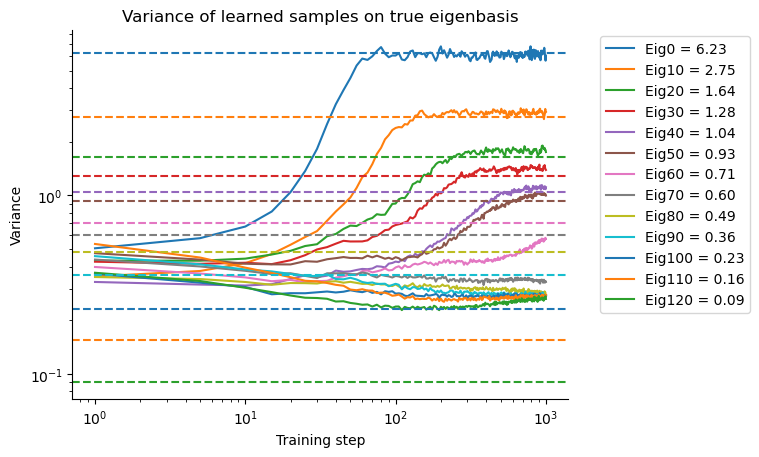

In [ ]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, None, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot])
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw")
plt.show()

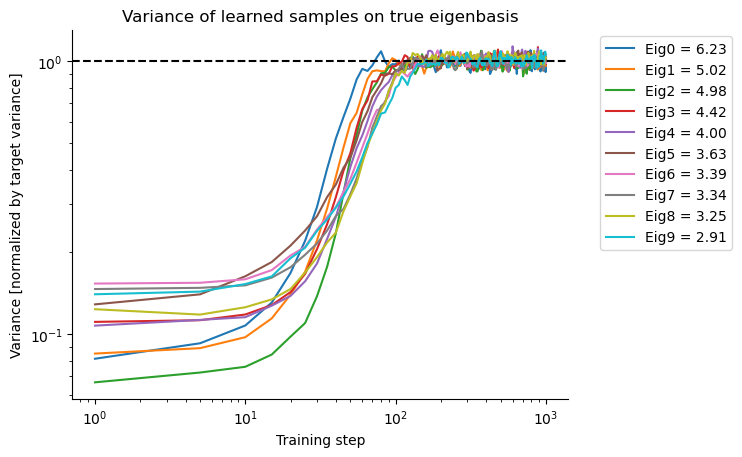

In [ ]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj.numpy() / true_cov_eigs.numpy())
slice2plot = slice(None, 10, 1)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot])
plt.axhline(1, color="k", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top10")
plt.show()

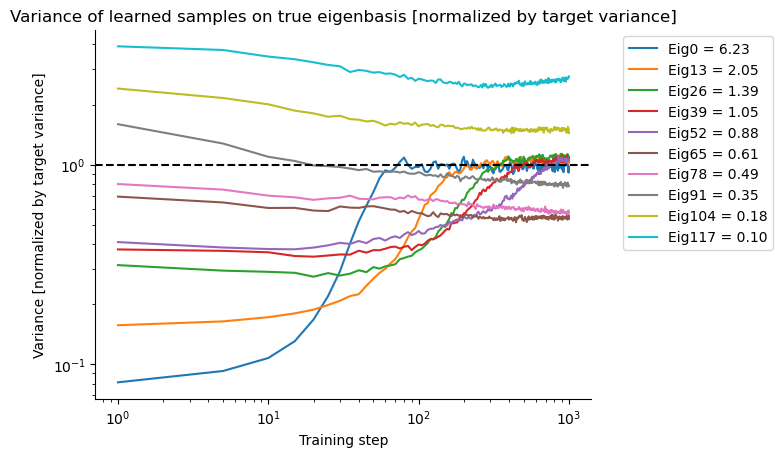

In [ ]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs).numpy()
slice2plot = slice(None, None, 13)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], )
plt.axhline(1, color="k", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis [normalized by target variance]")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_every10")
plt.show()